In [1]:
from sklearn.datasets import load_digits
import pandas as pd
from scipy import  stats
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import product
from scipy.io import loadmat
import networkx as nx
from functools import reduce
import json
import numpy as np
from unittest import TestCase, TextTestRunner
from matplotlib import colors

In [2]:
# imports from graph package
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from graph.triangulation.variable_elimination import triangulate_variable_elimination
from helper.entropy import entropy_matrix
from helper.functional import Composition
from graph.clique_graph import to_clique_graph
from graph.junction_tree import to_junction_tree
from graph.message_passing import adsorb_separator_potentials
from graph.assign_potentials import AssignPotentials
from graph.orient_junction_tree import orient_junction_forest
from graph.inference.most_probable_state import most_probable_state

### To do:
* Provide data in a convenient form

### Alternative approaches
* Neural networks and PCA http://ieeexplore.ieee.org/document/4564577/?reload=true

### Pedagogical considerations:
* Use as baseiline the most common pixel occurance (over all pixels)
* Use as baseline the most common occurence per pixel
* Try to hardcore make a joint contingency table. Here we should trap into the curse of dimensionality

### Some helper functions

In [3]:
"""Helper functions for graph"""

def undirected_graph(adjecency: np.array):
    return nx.from_numpy_matrix(adjecency)

def largest_clique_size(G: nx.Graph):
    return max(clique_sizes(G))

def clique_sizes(G:nx.Graph):
    cliques = nx.find_cliques(G)
    return map(len, cliques)

def n_of_clique_memberships_for_node(cliques, node):
    return sum(node in clique for clique in cliques)

def n_of_clique_memberships(G:nx.Graph):
    cliques = list(nx.find_cliques(G))
    nodes = G.nodes
    return [(node, n_of_clique_memberships_for_node(cliques, node)) for node in nodes]

class AdjecencyMatrixFromEntropy:
    """Compute adjecency matrix as boolean array from entropy"""
    
    def __init__(self, threshold_index:int):
        self.threshold_index = threshold_index
        
    def __call__(self, entropy: np.array):
        sorted_entropy_values = np.flip(np.sort(entropy.flatten()), axis=0)
        threshold = sorted_entropy_values[self.threshold_index]
        return entropy >= threshold
    
def get_given_pixels(noisy_digit: np.array):    
    given = dict()
    for i, d in np.ndenumerate(noisy_digit):
        if d < 2:
            given.update({i[0]: int(d)})
    return given

In [4]:
"""Helper functions for plotting"""

def show_digits(data: np.ndarray, figsize=(14, 7)):
    """Visualize data"""
    digits = data
    if len(data.shape) ==  1:
        digits = data.reshape(1, data.shape[0])
    fig = plt.figure(1, figsize=figsize)
    n_digits = digits.shape[0]
    gs = GridSpec(1, n_digits)
    # specify colors
    cmap = colors.ListedColormap(['white', 'black', 'gray'])
    bounds=[0,.5,1.5, 10]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    for idx in range(n_digits):
        ax = fig.add_subplot(gs[0, idx])
        image = digits[idx]
        ax.imshow(image.reshape(20,16), cmap=cmap, norm=norm)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.show()

In [5]:
"""Helper functions for data"""

def read_json_file(path):
    with open(path, encoding='utf-8') as data_file:
        data = json.loads(data_file.read())
    return data


def randomize_digit(digit, n_pixels_to_remove = 8*20):
    randomized = digit.copy()
    mask=np.zeros(20*16, dtype=bool)
    mask[: n_pixels_to_remove] = True
    np.random.shuffle(mask)
    randomized[mask] = 5 # encode missing pixel with value 5
    return randomized

def randomize_digits(digits, n_pixels_to_remove_per_digit = 8*20):
    randomized_digits = []
    for digit in range(digits.shape[0]):
        randomized = randomize_digit(digits[digit, :], n_pixels_to_remove_per_digit)
        randomized_digits.append(randomized)
    return np.array(randomized_digits)

### The problem
* The prolem is example 9.10 of the Book "Baysian Reasoning and Machine Leraning" (David Barber)
* Assume that we have binary digits (i.e. pixels which can only take the values zero and one) , where half of the pixels is not known.
* The task is to reconstruct the missing pixels
* The training data at hand are samples of digits with no pixels missing

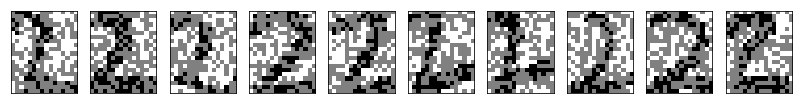

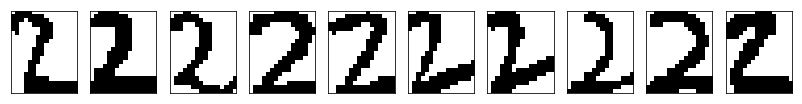

In [6]:
raw = read_json_file(path='../data/binary_alpha_digits.txt')
labels = np.array(raw['labels'])
data = np.array(raw['data'])
twos = data[labels == '2']
noisy_twos = randomize_digits(twos[:10])
show_digits(noisy_twos)
show_digits(twos[:10])

* ** Top row ** Examples of data we want to predict. Gray indicates missing pixels

* ** Bottom row ** Training data with no pixels missing

### Approach 
* The basic idea is to approximate the joint probability function of the pixel distribution by means of probabilistc graphs
* Within this context we may think of a graph where each node corresponds to a pixel of the image. The correlation between these pixels is encoded in the edge structure. Conversely, the approximations to the joint pdf are encoded in the edges that are missing. Based on this we would like to infer the most probable state of an image given the pixels values we know (in the above picture we know the pixels which are either white or black)


**Specifically we need to do the following steps:**

1. Construct a Markov Network where each pixel corresponds to a node
2. Add edges between nodes only if the pairwise in between pixel entropy (determined empirically, based on the training data) exceed a certain threshold.
3. Triangulate this graph
4. Construct clique graph
5. Construct junction tree
6. Assign potentials as empirical distributions between (pixels contained in) cliques and seperators 
7. Choose root node and orient junction tree
8. Adsorb seperator potentials by dividing each clique potential by its parent seperator potential

** Remark **

Steps 5-8 correspond Algorithm 9.4 "Learning of an unconstrained decomposable Markov network" in the Barber Book. 
#### Now wer are ready to go!

### Compute Entropy matrix

In [7]:
matrix_of_pairwise_entropies = entropy_matrix(twos)

### Train model
* We follow the steps outlined above
* Note that the lower the entropy threshold, the smaller the largest clique size in the (triangulated) graph
* This is important since we are computing probabilty tables for each clique. If the clique size were too high then we will run into memory errors (for the specific problems say a clique 10 pixels leads to a tensor of rank 10). 

In [8]:
ENTROPY_THRESHOLD_INDEX = 300

train = Composition(
            AdjecencyMatrixFromEntropy(ENTROPY_THRESHOLD_INDEX),
            undirected_graph,
            triangulate_variable_elimination,
            to_clique_graph,
            to_junction_tree,
            AssignPotentials(twos),
            orient_junction_forest,
            adsorb_separator_potentials)

trained = train(matrix_of_pairwise_entropies)

### Prediction
* in the first case assume that we have an image where all pixels are missing. What would be the most probable state then?

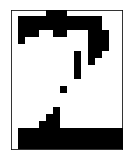

In [9]:
state = most_probable_state(trained, given=dict())
show_digits(state, figsize=(2,3))

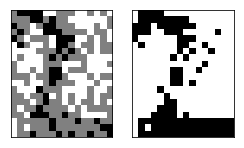

In [10]:
noisy_two = noisy_twos[0]
state = most_probable_state(trained,  given=get_given_pixels(noisy_two))
show_digits(np.array([noisy_two, state]), figsize=(4,3))

#### Some Remarks on Triangulating graphs
#### Defintion 
* An undirected graph G is triangulated if every loop of length 4 or more is chordal. 
* A chord is an edge that connects two non-adjecent nodes in a loop. 
* G is also called decomposable or chordal.

#### Theorem
The following properties for an undirected graph G are equivalent
* G is triangulated
* The clique graph of G has a junction tree
* There is an elimination ordering of G that does not lead to any added edges

#### Triangulation algorithms
* Triangulating a Graph  $G\mapsto \tilde G$ is not unique. So we wish to use this freedom in order to construct a triangulated graph $\tilde G$ with small clique sizes. This has a crucial advanted upon inference. We need less memory to construct the ensuing clique potentials. The problem of finding $\tilde G$ with smallest maximum clique size is NP hard. So we need some heuristics. They rely on the concept of variable elimination but differ in the way the sequence of elemeniated nodes is chosen.

#### Algorithm 1: Variable elimination
Repeat until Graph has no nodes
        1. Pick any non-deleted node x of G
        2. Add links to all neighbours of x
        3. Delete node x

One approach how to chose the order of nodes $\{x_i\}$ to be eliminated is the Rose-Tarjan elimination:

#### Algorithm 2: Node elemination order
        1. Eliminate all simplical nodes. 
        2. Eliminate node with minium numbers of links to be added

A node is simplical when no extra link is introduced between it's neighbors upon node removal. Of course this check has to be done after each node removal (except for the simplicial ones) - since the graph structure will eventually change

An alternative triangulation procedure is based on checking wheter a graph is triangulated. 

#### Algorithm 3: Maximum cardinality checking
        Choose any node and label it 1
        for i=2 to n:
            Choose the node with the most labeled neighbours and label it i
            If any two neighbours of i are not adjecent:
                FAIL
If there is more than one node with most labeled neighbours the tie may be broken arbritarily.       

#### Algorithm 4: Triangulate graph via maximum cardinality checking
        While Fail:
            Run algorithm 3
            if Fail:
                add link between failing nodes

### Visualize intermediate results for triangulated graph
1. Entropy heatmap
2. Adjecency matrix of untriangulated graph
2. Adjecency matrix of untriangulated graph
4. Number of cliques each pixel is member of in 
3. (Size of) clique distribution

In [12]:
# Build and triangulate graph again, based on the entropy matrix

markov_graph = Composition(
                AdjecencyMatrixFromEntropy(ENTROPY_THRESHOLD_INDEX), 
                undirected_graph)(matrix_of_pairwise_entropies)

triangulated_graph = triangulate_variable_elimination(markov_graph)

print('Triangulated graph is chordal: ', nx.is_chordal(triangulated_graph))
print('Largest clique size: ', largest_clique_size(triangulated_graph))
print('Number of cliques: ', len(list(nx.find_cliques(triangulated_graph))))

Triangulated graph is chordal:  True
Largest clique size:  18
Number of cliques:  303


In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def heatmap(a: np.ndarray, title=None, colorbar=False, ax=None, fig=None):
    if not ax:
        fig, ax = plt.subplots()
    im = ax.imshow(a, 
                   cmap='binary', 
                   #aspect='auto',
                   interpolation='nearest')
    ax.set_xlabel('pixel')
    ax.set_ylabel('pixel')
    #ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    if colorbar:    
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)   
    if title:
        ax.set_title(title)

    
def plot_clique_distribution(G: nx.Graph, title=None, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    sizes = list(clique_sizes(G))
    occs = np.array(sorted([[s, sizes.count(s)] for s in set(sizes)], key=lambda x: x[0]))
    ax.bar(occs[:, 0], occs[:, 1], color='green', alpha=.4)
    ax.set_xlabel('clique size')
    ax.set_ylabel('counts')
    if title:
        ax.set_title(title)
  

def plot_clique_memberships(G: nx.Graph, title=None, ax=None, fig=None):
    memberships = sorted(n_of_clique_memberships(G), key= lambda t: t[0])
    memberships_reshaped = np.array(list(map(lambda x:x[1], memberships))).reshape(20,16)
    heatmap(memberships_reshaped, title=title,  colorbar=True, ax=ax, fig=fig)

    
def plot_analyze_graph(entropies:np.array, markov_graph: nx.Graph, triangulated: nx.Graph):
    fig = plt.figure(figsize=(12,8))
    gs = GridSpec(2, 3, hspace=.5, vspace=.4)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[0, 2])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])#.set_aspect(1)
    
    
    heatmap(entropies, 
            title="Entropy", 
            colorbar=True,
            ax=ax0,  fig=fig)
    
    heatmap(nx.to_numpy_matrix(markov_graph), 
            title='Markov graph', 
            colorbar=False,
            ax=ax1, fig=fig)
    
    heatmap(nx.to_numpy_matrix(triangulated), 
            title='Triangulated', 
            colorbar=False,
            ax=ax2, fig=fig)
    
    plot_clique_memberships(triangulated, 
                            title='Clique memberships',
                            ax=ax3, fig=fig)
    
    plot_clique_distribution(triangulated, 
                             title='Clique distribution',
                             ax=ax4) 
    
    plt.show()    

In [36]:
"""heatmap(matrix_of_pairwise_entropies, title="pairwise pixel entropy", colorbar=True)
heatmap(nx.to_numpy_matrix(markov_graph), title='Graph edges of markov graph', colorbar=True)
heatmap(nx.to_numpy_matrix(triangulated_graph), title='Graph edges of markov graph', colorbar=True)
plot_clique_memberships(triangulated_graph, title='clique memberships for triangulated graph')
plot_clique_distribution(triangulated_graph, 'Clique distribution of triangulated graph')
"""

plot_analyze_graph(matrix_of_pairwise_entropies, markov_graph, triangulated_graph)
#plot_analyse_cliques(triangulated_graph)


TypeError: __init__() got an unexpected keyword argument 'vspace'